# Math 584 - Homework 5
*Diane PERES*

---

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as sio  # for loading matlab data
from scipy import stats
from statsmodels.tsa import stattools
from statsmodels.regression import linear_model
import warnings
warnings.filterwarnings('ignore')# get warning for complex type
import time 

## MSFT

In [2]:
dataDir = "./tickers/"
mats_MSFT = []
indices = ["03","04","05","06","07","10","11","12","13","14","17","18","19","20","21","24","25","26"]
for i in indices:## MSFT
    mats_MSFT.append( sio.loadmat( dataDir+"MSFT_201411"+i+".mat" ) )
    #print(dataDir+"MSFT_2014110"+i+".mat" )

# Exercice 1
In this exercise, you will compute the **execution costs** produced by the **TWAP** execution algorithm, using the ticker MSFT from Nov 3 through Nov 26, 2014, 10am–3:30pm, as your sample. In the test, use: 
* κ  **temporary** impact: κ = 0.005 
* S  midprice as the **unaffected** price
* 10 minutes as the size of the estimation window
* 3  minutes as the target execution time
* 1  second as the trading frequency (e.g., t = 0, 1, 2, . . . denotes the number of seconds)
* λ  **permanent** price impact coefficient.
The permanent price impact coefficient λ is estimated (using the least-squares linear regression) from the reduced frequency (i.e., using one-second frequency) sample via a linear (least-squares) regression of midprice increments on the increments of the order flow.

Implement the TWAP liquidation strategy with the initial inventory of Q_0 = 10000 shares. Back-test it using the rolling window method and plot the resulting **execution costs** across the trading (execution) windows. On the same plot, show the **theoretical expected execution costs** for each window. Then, compute the two sample **averages**, of the **realized** and of the **expected** costs, and compare them.


In [3]:
k = 0.005 # temporary impact
S = []    # midprice as the unaffected price
N = 60*10 # estimation window of size 10 minutes 
T = 60*3  # target execution time of size 3 minutes 
f = 10    # trading frequency 1 seconds
Q = [1e4]+[1e4*(T-(i-1)/T) for i in range(0,T)]
nu = -Q[0] /T

start  = 10*60*30         # 10h30
end    = 10*60*(30+11*30) # 15h30

In [4]:
S, dS, dOF = [], [], []
M = 0
for day in range(len(mats_MSFT)):
    LOB  = mats_MSFT[day]['LOB']
    Time = (np.array((LOB['EventTime'][0][0][:,0]))*1e-3)[start:end:f]#time in seconds, measured from NASDAQ from 10h30 to 15h30
    bid  = np.array(LOB['BuyPrice'][0][0]*1e-4)[start:end:f]
    ask  = np.array(LOB['SellPrice'][0][0]*1e-4)[start:end:f]
    bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
    askvol = np.array(LOB['SellVolume'][0][0]*1.0)
    
    OF  = list(np.sum(bidvol[start:end:f,:10],axis=1)-np.sum(askvol[start:end:f,:10],axis=1))
    dOF += list(np.diff(OF))    

    s   = list((ask[:,0]+bid[:,0])*0.5)
    S  += s
    dS += list(np.diff(S))    

    M+=len(Time)
    

In [5]:
X, cost, cost_th = [], [], [] #absolute PnL, trading cost, theoretical expected execution cost

for t in range(N,M-T):
    #print(f't = {t}')
    
    # Estimation Window 
    l, intercept, r, p, std_err = stats.linregress(dOF[t-N:t], dS[t-N:t])
    #print(f'λ = {l} \np = {p} \nr^2 = {r**2}')
    
    # Trading window
    x=0
    for i in range(0,T):
        x -= nu* (l*(Q[i+1]-Q[0]) + k*nu + S[t+i+1])
        #print(f'x = {x}')
    X.append(x)

    # Execution cost
    c = Q[0]*S[t]-x
    #print(f'c = {c}')
    cost.append(c)
    
    # theoretical expected execution cost
    c_th = (Q[0]**2)*k/T + l*(Q[0]**2)*(T+1)/(2*T)
    #print(f'c = {c_th}\n')
    cost_th.append(c_th)
    

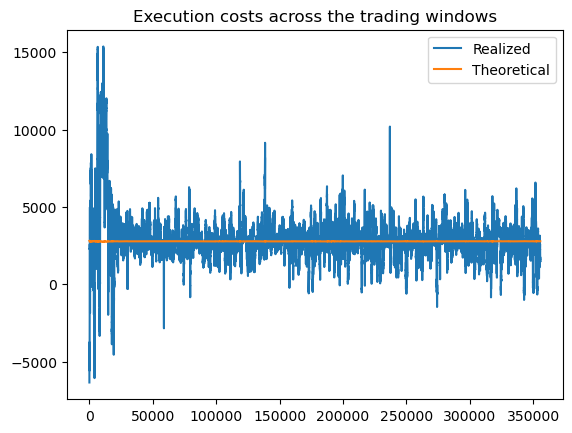

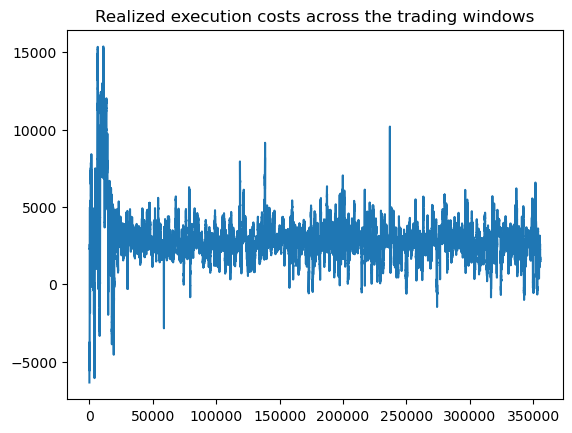

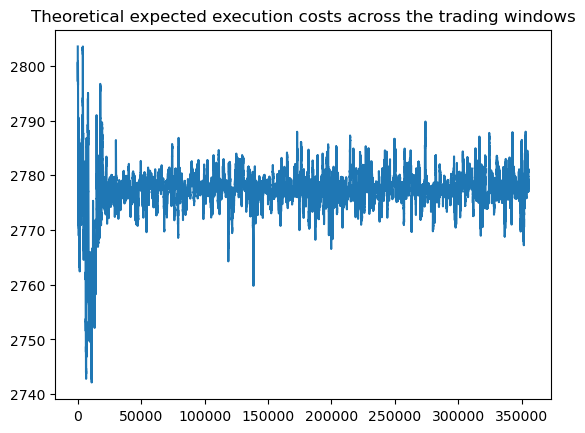

The average of the realized execution costs across the trading windows is 2932.3208310514665.
The average of the expected execution costs across the trading windows is 2777.337531492062.



In [6]:
plt.plot(cost, label = 'Realized')
plt.plot(cost_th, label = 'Theoretical')
plt.title('Execution costs across the trading windows')
plt.legend(loc='best')
plt.show()

plt.plot(cost)
plt.title('Realized execution costs across the trading windows')
plt.show()

plt.plot(cost_th)
plt.title('Theoretical expected execution costs across the trading windows')
plt.show()

#sample averages
mu    = np.mean(cost)
mu_th = np.mean(cost_th)

print(f'The average of the realized execution costs across the trading windows is {mu}.\nThe average of the expected execution costs across the trading windows is {mu_th}.\n')


# Exercice 2
In the discrete-time version of **Almgren-Chriss model**, described in Chapter 5, consider an agent who aims to liquidate the initial inventory Q0 > 0 by time T. The agent is flexible about liquidating the inventory completely, hence, she aims to maximize: max_ν \[EX^ν_T − α(Q^ν_T )^2\] with some (large) constant α > 0, but **without** the constraint Q^ν_T = 0. Find the **optimal liquidation strategy** in a feedback form, using the DPP.

Hint: to solve the recursive DPP equation for the value function V (t, q, s), you can use the ansatz V(t,q,s)=a(t)q^2 +b(t)qs+c(t)s^2 +d(t)q+e(t)s+f(t) and derive the recursive equations for (a, b, c, d, e, f ), as well as the formula for the optimal strategy ν^∗ in a feedback form, expressed via (a, b, c, d, e, f ). This counts as a complete solution.